In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.cluster import KMeans

def custom_grouping(index):
    return index // 1000

# counts=[0]
def distribute_payload(r):
  # counts[0]+=1
  duration=r['duration']
  start=int(r['submission_time'])
  payload=4096
  per_unit_time=payload/max(duration,1.)
  residue=payload-per_unit_time*math.floor(duration)

  payloads=[per_unit_time]*math.floor(duration)
  if residue>0:
     payloads.append(residue)

  submission_times=range(start, start+math.ceil(duration), 1)

  return pd.DataFrame([{'payload': a, 'submission_time':b}
                       for a,b in zip(payloads, submission_times)])


In [2]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# # Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/STL/4K/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
# #df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/4K/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = df['submission_time'] - df.iloc[0].submission_time
df['duration'] = df['duration'] / 1e6

In [3]:
def process(df, max_size, outfile):
  class Writer(object):
    def __init__(self, max_size, outfile):
      self.dfs=[]
      self.counter=0
      self.total_size=0
      self.max_size=max_size
      self.fname=outfile

    def add(self, df):
      self.dfs.append(df)
      self.total_size+=len(df)
      print(f"Added len={len(df)}")
      self.maybe_write()

    def maybe_write(self, final=False):
      if self.total_size>self.max_size or final:
        if len(self.dfs)==0:
          print("Nothing to write")
        else:
          d=pd.concat(self.dfs, ignore_index=True)

          #additionally one group by sum can be done here to potentially reduce the size
          original_len=len(d)
          #d=d.groupby('submission_time').agg({'payload': 'sum'}).reset_index()
          #print(f"groub by size reduced from {original_len} --> {len(d)}")

          full_fname=f"chunks/stl/{self.fname}_{self.counter}"
          d.to_csv(full_fname)
          print(f"wrote len={len(d)} to {full_fname}")
          del d
        if final:
          print("wrote final")
        self.counter+=1
        self.total_size=0
        self.dfs=[]

  w=Writer(max_size, outfile)
  for _,r in df.iterrows():
    w.add(distribute_payload(r))
  w.maybe_write(final=True)

prefix='stl_chunks'


In [4]:
process(df, 10000000, prefix)

Added len=10
Added len=10
Added len=10
Added len=10
Added len=10
Added len=10
Added len=10
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=12
Added len=12
Added len=12
Added len=12
Added len=12
Added len=12
Added len=12
Added len=12
Added len=13
Added len=13
Added len=13
Added len=13
Added len=13
Added len=14
Added len=14
Added len=14
Added len=14
Added len=14
Added len=14
Added len=15
Added len=15
Added len=15
Added len=15
Added len=15
Added len=15
Added len=15
Added len=15
Added len=16
Added len=16
Added len=16
Added len=16
Added len=16
Added len=16
Added len=16
Added len=17
Added len=8
Added len=17
Added len=8
Added len=8
Added len=7
Added len=8
Added len=7
Added len=7
Added len=12
Added len=11
Added len=11
Added len=11
Added len=11
Added len=22
Added len=11
Added len=22
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=11
Added len=10
Added len=10
Added 

KeyboardInterrupt: 

In [ ]:
#@title sum up the payloads for each interval
prefix='chunks'
num_chunks=10
df2=pd.concat([pd.read_csv(f"chunks/stl/{prefix}_{x}") for x in range(num_chunks)])
df3=df2.groupby('submission_time').agg({'payload': 'sum'}).reset_index()
df3
df3['cumulative_gb'] = df3['payload'].cumsum() / (1024 ** 3)
df3['payload'] = df3['payload'] / (1024)
print("total: " + str(df3['payload'].sum()) + "#items: " + str(df3.index[-1]) + " average: " + str(df3['payload'].sum()/df3.index[-1]))
print("Mean: " + str(df3['payload'].mean()))

total: 2671084.000000001#items: 1611322 average: 1.6576972200466455
Mean: 1.6576961912664319


In [ ]:
#@title ensure that the sum of the payloads match up

#assert df2.payload.sum()==len(df)*4096
#assert df3.payload.sum()==len(df)*4096

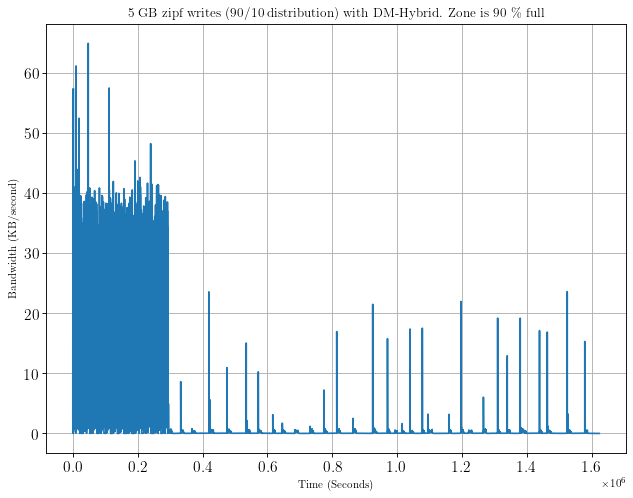

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 100000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df3.submission_time, df3.payload)
#plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
plt.xlabel('Time (Seconds)')
plt.ylabel('Bandwidth (KB/second)')
#plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
#plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)
#plt.legend(loc='center right', fontsize=14)
plt.grid(True)  # Optionally, add grid lines
plt.title("5 GB zipf writes (90/10 distribution) with DM-Hybrid. Zone is 90 \% full")
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/4K_90Util_STL_BW.png', bbox_inches='tight')
plt.show()


In [ ]:
plt.plot(df_grouped['cumulative_gb'], df_grouped['payload'])
plt.xlabel('Cumulative GBs written')
plt.ylabel('Bandwidth (MB/second)')
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
plt.grid(True)  # Optionally, add grid lines
plt.title("5 GB zipf writes (90/10 distribution) with DM-Hybrid. Zone is 90 \% full")
plt.show()

NameError: name 'df_grouped' is not defined